In [4]:
## Should have all the same signal processing functions from the signal package in R:
## https://cran.r-project.org/web/packages/signal/signal.pdf
from scipy.signal import butter, lfilter

## https://docs.scipy.org/doc/scipy/reference/signal.html

import pandas as pd
import numpy as np
import csv
import glob
import matplotlib.pyplot as plt
import datetime

In [5]:
output_path = r'/Users/dancohen/Dropbox/E4 stuff/test data/EDA_All_Data'

Define helper functions to convert from the unix timestamp to UTC and to add time to an input date based on a sample rate (will be 4hz for this code)

In [28]:
def get_utc_date_time(ts):
    return pd.to_datetime(ts, unit='s', infer_datetime_format = True)
#.strftime('%H:%M:%S:%f')

def add_fs(sample_rate, date):
    return date + datetime.timedelta(milliseconds=1.0/(sample_rate) * 1000.0)

Found some code on stack overflow and in SciPy's community website that implements a band pass butterworth filter for a 1d array: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html#.  I dont know what order filter we need for this data, but for exploratory data analysis, it appears to work ok

In [29]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

## May need to better understand which order filter is needed for this dataset
def butter_bandpass_filter(data, lowcut, highcut, fs, column_name, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    y = pd.DataFrame(y, columns=[column_name])
    return y

Helper function that will generate the list of timestamps that will be added as a new column to our dataframe

In [30]:
def time_range(df_length, start_timestamp):
    # Generate date time range based on sample rate and starting timestamp
    time_range = []
    t_0 = get_utc_date_time(float(start_timestamp))
    time_range.append(t_0)
    
    next_date = t_0
    
    for count in range(df_length-1):
        next_date = add_fs(sample_rate, next_date)
        time_range.append(next_date)
    return time_range

Helper function that returns a list of floats iterated upwards by sample rate

In [155]:
def iterate_sample_rate(df_length, fs):
    # returns list of floats starting from zero iterated upward by sample rate
    result = []
    curr_time = 0.0
    result.append(curr_time)
    
    for i in range(df_length-1):
        curr_time += 1.0/fs
        result.append(curr_time)
    return result

Helper function that finds the time difference between 2 unix timestamps

In [127]:
def t_0_diff_seconds(t_0, date_time):
    return (date_time - pd.to_datetime(t_0, unit='s', infer_datetime_format = True)).total_seconds()

Change file_path to point to where the folders containing EDA data will be

In [32]:
file_path = r'/Users/dancohen/Dropbox/E4 stuff/test data'
output_path = r'/Users/dancohen/Dropbox/E4 stuff/test data/EDA_All_Data'
all_folders = glob.glob(file_path + "/PRF*")

In [33]:
fs = 4.0 ## Sampling frequency.  This test data was gathered at 4hz
lowcut = 0.05 ## Lower bound for the filter, as directed by Empatica documentation
highcut = 1.0  ## Upper bound for the filter, as directed by Empatica documentation

Now that we have a list of file paths that each will contain the files we are interested in, we can start to do work with the csv files they contain

In [169]:
eda_list = []
script_1_2 = []
script_2_3 = []
script_3_end = []

for folder in all_folders:
    spl = folder.split('/')
    
    #Folder names are 'PRF###' (participant ID) and we are interested in the ID
    part_id = spl[len(spl)-1][3:]
    
    eda_df_raw = pd.read_csv(folder+"/eda.csv")
    starting_timestamp = eda_df_raw.columns[0]
    sample_rate = eda_df_raw[starting_timestamp][0]
    
    # Grab the csv containing the timestamps that mark the start and end times of the scripts
    script_times = pd.read_csv(folder+"/tags.csv", header=None)
    script_times = script_times.apply(lambda x: pd.to_datetime(x, unit='s'))
    
    try:
        begin_s1 = t_0_diff_seconds(starting_timestamp, script_times.loc[1].iat[0])
        end_s1 = t_0_diff_seconds(starting_timestamp, script_times.loc[2].iat[0])

        begin_s2 = t_0_diff_seconds(starting_timestamp, script_times.loc[3].iat[0])    
        end_s2 = t_0_diff_seconds(starting_timestamp, script_times.loc[4].iat[0])

        begin_s3 = t_0_diff_seconds(starting_timestamp, script_times.loc[5].iat[0])
        end_s3 = t_0_diff_seconds(starting_timestamp, script_times.loc[6].iat[0])
    except Exception as err:
        print("Error occurred parsing tags.csv for PRF{}.  Error: {}. This file will be skipped.".format(part_id, err))
        continue
    
    
    # Drop the first 2 rows, as we already have the timestamp and sample rate
    eda_df_raw = eda_df_raw.drop(eda_df_raw.index[0:2])
    
    # Rename the column to the participant ID
    eda_df_raw = eda_df_raw.rename(columns={starting_timestamp: part_id})
    
    # Generate data frame with timestamps iterating upwards starting at t_0
    timestamps = pd.DataFrame(time_range(len(eda_df_raw), starting_timestamp))
    
    # Generate list of timings starting from 0 iterated upwards by 1/sample rate seconds
    time_col = iterate_sample_rate(len(eda_df_raw), sample_rate)
    
    eda_df_filtered = butter_bandpass_filter(eda_df_raw[part_id], lowcut, highcut, fs, part_id)
    eda_df_filtered['Timestamp'] = time_col
    
    # Now, we can parse out data that we are interested in.  We will get 3 dataframes, one with data between 
    # the end of script 1 and beginning of script 2, one between the end of script 2 and beginning of script 3
    # and one that has the data from end of script 3 to the end of the timing
    eda_df_times = eda_df_filtered.copy()
    eda_df_times['Timestamp'] = time_col
    df = eda_df_times.set_index('Timestamp')
    df_1_2 = df.loc[(df.index >= end_s1) & (df.index < begin_s2)]
    script_1_2.append(df_1_2)
    
    df_2_3 = df.loc[(df.index >= end_s2) & (df.index < begin_s3)]
    script_2_3.append(df_2_3)

    df_3_end = df.loc[(df.index >= end_s3)]
    script_3_end.append(df_3_end)

    #Set the index to be the timestamp, so that when we concatenate the data together we get an easy join
    eda_df_filtered = eda_df_filtered.set_index('Timestamp')
    eda_list.append(eda_df_filtered.transpose())

Error occurred parsing tags.csv for PRF020.  Error: 'the label [6] is not in the [index]'. This file will be skipped.


In [170]:
eda_all_participants = pd.concat(eda_list).transpose()
eda_all_participants

,012,205,002
Timestamp,,,
0.00,0.035781,0.011937,0.001216
0.25,0.224242,0.073250,0.008277
0.50,0.613521,0.188914,0.023869
0.75,0.984608,0.260583,0.037354
1.00,1.104027,0.197817,0.033335
1.25,1.075770,0.071141,0.016045
1.50,1.103839,0.007552,0.003916
1.75,1.127801,0.009351,0.001096
2.00,0.948930,-0.003641,-0.001983


In [171]:
eda_all_participants.to_csv(output_path+"/EDA_All_Data.csv")

Now, we can output 3 separate files representing the script timings.  One for the data between end of script 1 and beginning of script 2, one for end of script 2 and beginning of script 3 and one for end of script 3 and end of the data.

Use the axis=1 option to concatenate (defaulting to an outer join) along the timestamp axis

In [172]:
output_1_2 = pd.concat(script_1_2, axis=1)
output_2_3 = pd.concat(script_2_3, axis=1)
output_3_end = pd.concat(script_3_end, axis=1)

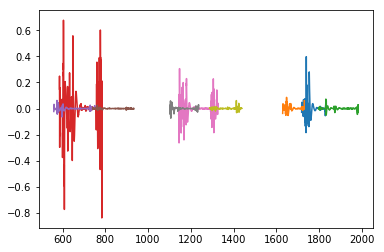

In [173]:
plt.plot(output_3_end)
plt.plot(output_1_2)
plt.plot(output_2_3)
plt.show()

In [175]:
output_1_2.to_csv(output_path+"/Between_S1_S2.csv", float_format='%.6f')
output_2_3.to_csv(output_path+"/Between_S2_S3.csv", float_format='%.6f')
output_3_end.to_csv(output_path+"/Between_S3_End.csv", float_format='%.6f')